🌞 Renewable Energy Forecasting - ML Deployment Script

### Dataset Preview (First 5 Rows)


,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,RENEWABLE,TOT,KTOE,A,1960,4436.932,NaN
1,AUS,RENEWABLE,TOT,KTOE,A,1961,4490.510,NaN
2,AUS,RENEWABLE,TOT,KTOE,A,1962,4407.097,NaN
3,AUS,RENEWABLE,TOT,KTOE,A,1963,4628.738,NaN
4,AUS,RENEWABLE,TOT,KTOE,A,1964,4497.396,NaN



### Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15904 entries, 0 to 15903
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LOCATION    15904 non-null  object 
 1   INDICATOR   15904 non-null  object 
 2   SUBJECT     15904 non-null  object 
 3   MEASURE     15904 non-null  object 
 4   FREQUENCY   15904 non-null  object 
 5   TIME        15904 non-null  int64  
 6   Value       12017 non-null  float64
 7   Flag Codes  3887 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 994.1+ KB
None

### Dataset Description (Statistics)


,TIME,Value
count,15904.000000,1.201700e+04
mean,1987.500000,1.322108e+04
std,16.163738,9.203502e+04
min,1960.000000,0.000000e+00
25%,1973.750000,9.580000e+00
50%,1987.500000,7.486000e+01
75%,2001.250000,1.816018e+03
max,2015.000000,1.894019e+06



'TIME' is missing or numeric. Creating automatic Time column.

📊 MODEL EVALUATION
✅ Mean Squared Error: 7205987207.6842
✅ R² Score: -0.0060

### Feature Importances


,Feature,Importance
0,TIME,1.0



💾 Model and scaler saved!

⚠️ New CSV not found. Switching to manual input mode.

Enter values for features to predict:


TIME:  2



✅ Prediction Completed:


,TIME,Predicted_Value,Time
0,-144.702839,2207.897054,2025-09-13 19:16:41.113707


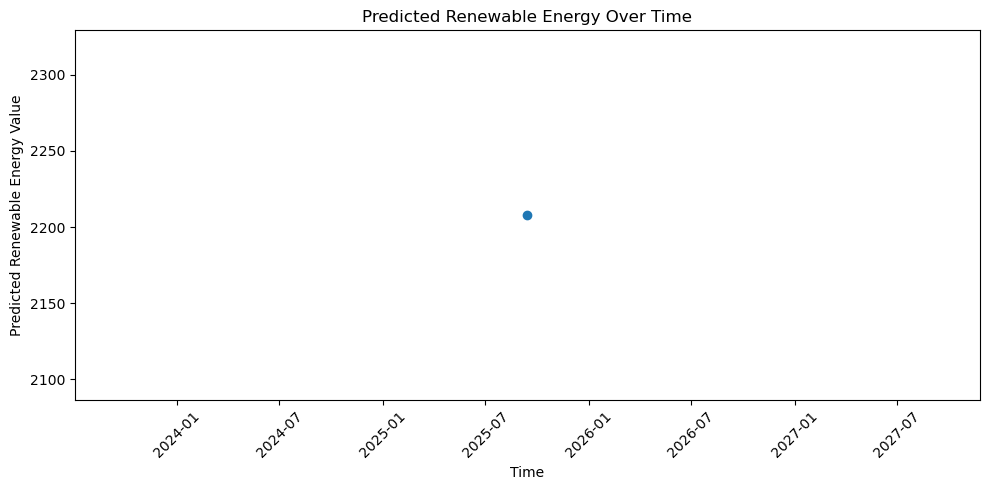

In [6]:
# ======================================================
# FINAL PROJECT - Renewable Energy ML Deployment Script
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import os

print("=====================================================")
print("🌞 Renewable Energy Forecasting - ML Deployment Script")
print("=====================================================")

# ===== Step 1: Load Dataset =====
file_path = "renewable_energy/renewable_energy.csv"
df = pd.read_csv(file_path)
print("\n### Dataset Preview (First 5 Rows)")
display(df.head())

print("\n### Dataset Info")
print(df.info())

print("\n### Dataset Description (Statistics)")
display(df.describe())

# ===== Step 2: Handle Time Column =====
time_col = "TIME"
if time_col not in df.columns or pd.api.types.is_numeric_dtype(df[time_col]):
    print(f"\n'{time_col}' is missing or numeric. Creating automatic Time column.")
    df['Time'] = pd.date_range(start=datetime.now(), periods=len(df), freq='min')
    time_col = 'Time'
else:
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    df = df.dropna(subset=[time_col])

# ===== Step 3: Drop unnecessary columns =====
drop_cols = ["INDICATOR", "SUBJECT", "MEASURE", "FREQUENCY", "Flag Codes"]
df = df.drop(columns=[col for col in drop_cols if col in df.columns])
df = df.dropna(subset=["Value"])  # drop rows missing target

# ===== Step 4: One-hot encode categorical columns =====
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if "Value" in categorical_cols:
    categorical_cols.remove("Value")
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# ===== Step 5: Define Features (X) and Target (y) =====
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
x_cols = [col for col in numeric_cols if col != "Value"]
y_col = "Value"

X = df[x_cols].copy()
y = df[y_col]

# ===== Step 6: Scale Features =====
scaler = StandardScaler()
X[x_cols] = scaler.fit_transform(X[x_cols])

# ===== Step 7: Train-Test Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== Step 8: Train RandomForest Model =====
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# ===== Step 9: Model Evaluation =====
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\n📊 MODEL EVALUATION")
print(f"✅ Mean Squared Error: {mse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# Feature Importance
importances = model.feature_importances_
importance_df = pd.DataFrame({"Feature": x_cols, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print("\n### Feature Importances")
display(importance_df)

# ===== Step 10: Save Model + Scaler =====
os.makedirs("renewable_energy", exist_ok=True)
joblib.dump(model, "renewable_energy/renewable_energy_model.pkl")
joblib.dump(scaler, "renewable_energy/renewable_energy_scaler.pkl")
print("\n💾 Model and scaler saved!")

# ===== Step 11: Batch Prediction from CSV if exists =====
new_data_path = "renewable_energy/new_data.csv"
if os.path.exists(new_data_path):
    df_new = pd.read_csv(new_data_path)
    print("\n### New CSV Data Preview:")
    display(df_new.head())
    
    # Handle categorical
    cat_cols_new = df_new.select_dtypes(include=['object']).columns.tolist()
    df_new = pd.get_dummies(df_new, columns=cat_cols_new, drop_first=True)
    
    # Align columns
    for col in x_cols:
        if col not in df_new.columns:
            df_new[col] = 0
    df_input = df_new[x_cols]
    
    # Scale
    df_input[x_cols] = scaler.transform(df_input[x_cols])
    
    # Predict
    df_input['Predicted_Value'] = model.predict(df_input)
    
    # Add Time column if missing
    if time_col not in df_input.columns:
        df_input[time_col] = pd.date_range(start=datetime.now(), periods=len(df_input), freq='min')
    
    # Save predictions
    df_input.to_csv("renewable_energy/predicted_results.csv", index=False)
    print("\n✅ Predictions saved to 'predicted_results.csv'")
    
else:
    # ===== Step 12: Manual Input =====
    print("\n⚠️ New CSV not found. Switching to manual input mode.")
    new_values = []
    print("\nEnter values for features to predict:")
    for feature in x_cols:
        val = float(input(f"{feature}: "))
        new_values.append(val)
    input_df = pd.DataFrame([new_values], columns=x_cols)
    
    # Scale
    input_df[x_cols] = scaler.transform(input_df[x_cols])
    
    # Predict
    prediction = model.predict(input_df)[0]
    input_df['Predicted_Value'] = prediction
    input_df[time_col] = datetime.now()
    
    print("\n✅ Prediction Completed:")
    display(input_df)

# ===== Step 13: Plot Predictions vs Time =====
try:
    plt.figure(figsize=(10,5))
    if os.path.exists(new_data_path):
        plt.plot(df_input[time_col], df_input['Predicted_Value'], marker='o', linestyle='-')
    else:
        plt.plot(input_df[time_col], input_df['Predicted_Value'], marker='o', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("Predicted Renewable Energy Value")
    plt.title("Predicted Renewable Energy Over Time")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("⚠️ Could not plot predictions:", e)


🌞 Renewable Energy Forecasting - ML Deployment Script

### Dataset Preview (First 5 Rows)


,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,RENEWABLE,TOT,KTOE,A,1960,4436.932,NaN
1,AUS,RENEWABLE,TOT,KTOE,A,1961,4490.510,NaN
2,AUS,RENEWABLE,TOT,KTOE,A,1962,4407.097,NaN
3,AUS,RENEWABLE,TOT,KTOE,A,1963,4628.738,NaN
4,AUS,RENEWABLE,TOT,KTOE,A,1964,4497.396,NaN



### Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15904 entries, 0 to 15903
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LOCATION    15904 non-null  object 
 1   INDICATOR   15904 non-null  object 
 2   SUBJECT     15904 non-null  object 
 3   MEASURE     15904 non-null  object 
 4   FREQUENCY   15904 non-null  object 
 5   TIME        15904 non-null  int64  
 6   Value       12017 non-null  float64
 7   Flag Codes  3887 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 994.1+ KB
None

### Dataset Description (Statistics)


,TIME,Value
count,15904.000000,1.201700e+04
mean,1987.500000,1.322108e+04
std,16.163738,9.203502e+04
min,1960.000000,0.000000e+00
25%,1973.750000,9.580000e+00
50%,1987.500000,7.486000e+01
75%,2001.250000,1.816018e+03
max,2015.000000,1.894019e+06



📊 MODEL EVALUATION
✅ Mean Squared Error: 7205987207.6842
✅ R² Score: -0.0060

### Feature Importances


,Feature,Importance
0,TIME,1.0



💾 Model and scaler saved!

⚠️ New CSV not found. Switching to manual input mode.

Enter values for features to predict:


TIME:  1234



✅ Prediction Completed:


,TIME,Predicted_Value
0,-55.138412,2207.897054


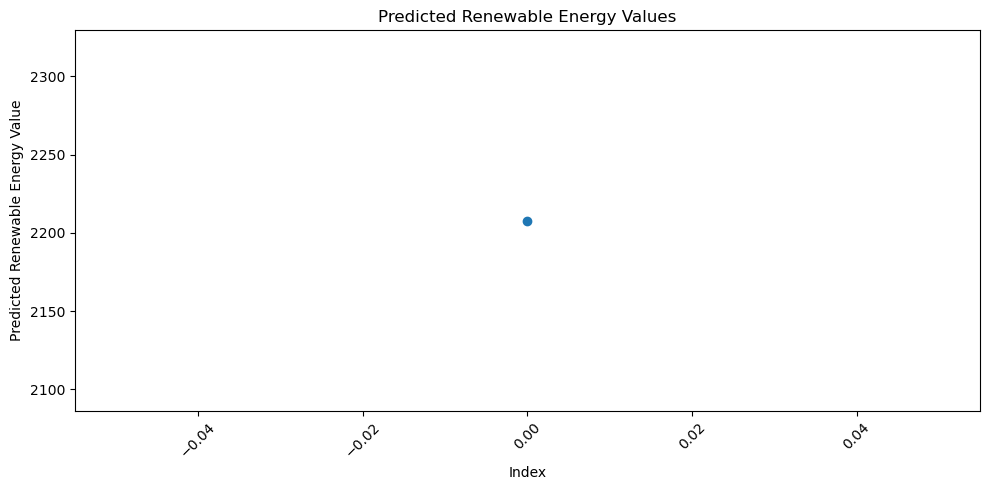

In [7]:
# ======================================================
# FINAL PROJECT - Renewable Energy ML Deployment Script
# ======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import os

print("=====================================================")
print("🌞 Renewable Energy Forecasting - ML Deployment Script")
print("=====================================================")

# ===== Step 1: Load Dataset =====
file_path = "renewable_energy/renewable_energy.csv"
df = pd.read_csv(file_path)
print("\n### Dataset Preview (First 5 Rows)")
display(df.head())

print("\n### Dataset Info")
print(df.info())

print("\n### Dataset Description (Statistics)")
display(df.describe())

# ===== Step 2: Drop unnecessary columns =====
drop_cols = ["INDICATOR", "SUBJECT", "MEASURE", "FREQUENCY", "Flag Codes"]
df = df.drop(columns=[col for col in drop_cols if col in df.columns])
df = df.dropna(subset=["Value"])  # drop rows missing target

# ===== Step 3: One-hot encode categorical columns =====
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if "Value" in categorical_cols:
    categorical_cols.remove("Value")
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# ===== Step 4: Define Features (X) and Target (y) =====
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
x_cols = [col for col in numeric_cols if col != "Value"]
y_col = "Value"

X = df[x_cols].copy()
y = df[y_col]

# ===== Step 5: Scale Features =====
scaler = StandardScaler()
X[x_cols] = scaler.fit_transform(X[x_cols])

# ===== Step 6: Train-Test Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== Step 7: Train RandomForest Model =====
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# ===== Step 8: Model Evaluation =====
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\n📊 MODEL EVALUATION")
print(f"✅ Mean Squared Error: {mse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# Feature Importance
importances = model.feature_importances_
importance_df = pd.DataFrame({"Feature": x_cols, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print("\n### Feature Importances")
display(importance_df)

# ===== Step 9: Save Model + Scaler =====
os.makedirs("renewable_energy", exist_ok=True)
joblib.dump(model, "renewable_energy/renewable_energy_model.pkl")
joblib.dump(scaler, "renewable_energy/renewable_energy_scaler.pkl")
print("\n💾 Model and scaler saved!")

# ===== Step 10: Batch Prediction from CSV if exists =====
new_data_path = "renewable_energy/new_data.csv"
if os.path.exists(new_data_path):
    df_new = pd.read_csv(new_data_path)
    print("\n### New CSV Data Preview:")
    display(df_new.head())
    
    # Handle categorical
    cat_cols_new = df_new.select_dtypes(include=['object']).columns.tolist()
    df_new = pd.get_dummies(df_new, columns=cat_cols_new, drop_first=True)
    
    # Align columns
    for col in x_cols:
        if col not in df_new.columns:
            df_new[col] = 0
    df_input = df_new[x_cols]
    
    # Scale
    df_input[x_cols] = scaler.transform(df_input[x_cols])
    
    # Predict
    df_input['Predicted_Value'] = model.predict(df_input)
    
    # Save predictions
    df_input.to_csv("renewable_energy/predicted_results.csv", index=False)
    print("\n✅ Predictions saved to 'predicted_results.csv'")
    
else:
    # ===== Step 11: Flexible Manual Input =====
    print("\n⚠️ New CSV not found. Switching to manual input mode.")
    new_values = []
    
    print("\nEnter values for features to predict:")
    for feature in x_cols:  # dynamically ask for all features
        val = float(input(f"{feature}: "))
        new_values.append(val)
    input_df = pd.DataFrame([new_values], columns=x_cols)
    
    # Scale
    input_df[x_cols] = scaler.transform(input_df[x_cols])
    
    # Predict
    prediction = model.predict(input_df)[0]
    input_df['Predicted_Value'] = prediction
    
    print("\n✅ Prediction Completed:")
    display(input_df)

# ===== Step 12: Plot Predictions =====
try:
    plt.figure(figsize=(10,5))
    if os.path.exists(new_data_path):
        plt.plot(range(len(df_input)), df_input['Predicted_Value'], marker='o', linestyle='-')
    else:
        plt.plot(range(len(input_df)), input_df['Predicted_Value'], marker='o', linestyle='-')
    plt.xlabel("Index")
    plt.ylabel("Predicted Renewable Energy Value")
    plt.title("Predicted Renewable Energy Values")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("⚠️ Could not plot predictions:", e)
